In [1]:
import warnings
warnings.filterwarnings('ignore')


from seabreeze.spectrometers import list_devices, Spectrometer
import seabreeze
seabreeze.use('pyseabreeze')


# import luxpy as lx >>> Only if you want to confirm multiple color swatches on the MacBeth Color Checker 
# (install at the anaconda prompt using <pip install luxpy>)

import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
from numpy import savetxt
from numpy import genfromtxt
import pandas as pd
%matplotlib inline

##### ALLOW Integrating Sphere Lamp to warm up for 30 minutes.  This will stabilize the lamp spectrum (filament heats up quickly, but the lamp envelop, which has to reach a stable temperature for the halogenation process to work, takes more time.  Otherwise, your baseline may wander during your testing.

##### Next step, set up the parameters to provide strong S/N values.  We are going to determine the integration time such that the maximum counts falls between (or near) 60,000 and 65,000.  The CCD is a 16-bit device; meaning 2<sup>16</sup> is the saturation point of the detector (the detector saturates at 65536).

##### To do this, we will use Spectralon reference (pressed PTFE developed by LabSphere).  Place the Spectralon reference over the sample port on the ISP-REF Integrating Sphere.  For more information about the ISP-REF Integrating Sphere, please see https://www.youtube.com/watch?v=hf5bM7cX6NI.  NOTE - set the Integrating Sphere to measure diffuse reflectance; use the quartz halogen lamp within the Integrating Sphere.  Also - our set-up uses a Schott Glass (BG-34) positioned between the Integrating Sphere and the sprectroradiometer to enhance the blue region of the spectrum.  The transmission of BG-34 is shown here --> https://www.pgo-online.com/intl/curves/optical_glassfilters/BG34.html

In [2]:
integration_time = np.arange(1000, 30000, 250)

##### NOTE - The integration time range is specifically set up for the IS.  If the int_time results in an empty list, the range will need to be increased (eg change 30000 to 60000 for example).  

In [3]:
Spectrometer.from_first_available()
devices = list_devices()
spec = Spectrometer(devices[0])

In [4]:
int_time = []

for i in range(len(integration_time)):
    spec.integration_time_micros(integration_time[i])

    def scan_to_average(scans):
        spectra = []
    
        for j in np.arange(scans+1):
            spectra.append(spec.intensities())
            
        return spectra
    
    scans = 2 # You can change the number of scans for your convenience.
    
    Spectralon = np.mean(scan_to_average(scans), axis=0)
    
    if np.amax(Spectralon) >= 59000. and np.amax(Spectralon) <= 64000.:
        int_time.append(integration_time[i])
        break
    else:
        continue
        
spec.close()

In [5]:
int_time

[9750]

In [6]:
Spectrometer.from_first_available()
devices = list_devices()
spec = Spectrometer(devices[0])

spec.integration_time_micros(int_time[0])

def scan_to_average(scans):
    
    spectra = []
    for i in np.arange(scans+1):
        spectra.append(spec.intensities())
            
    return spectra
    
scans = 50

teflon = np.mean(scan_to_average(scans), axis=0)[110:110+1120]

wavelengths = spec.wavelengths()[110:110+1120]

spec.close()

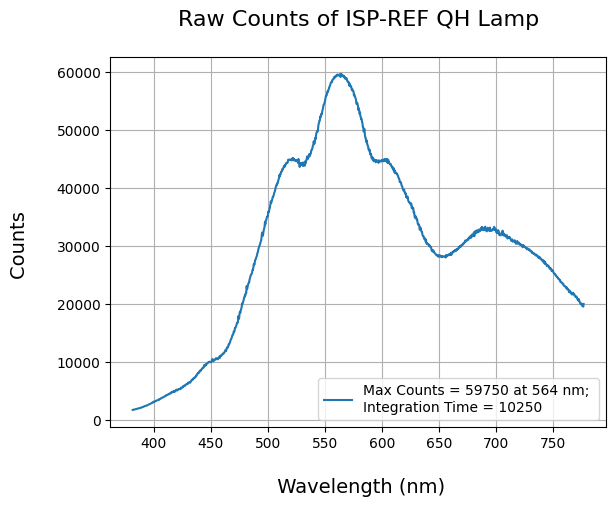

In [7]:
plt.plot(wavelengths, teflon, label = 'Max Counts = '+str(int(np.amax(teflon)))+ ' at '+ str(int(wavelengths[np.where(teflon == teflon.max())[0][0]]))+' nm; \nIntegration Time = '+str(int_time[0]))
plt.ylabel('Counts \n', fontsize = 14)
plt.xlabel('\n Wavelength (nm)', fontsize = 14)
plt.title('Raw Counts of ISP-REF QH Lamp\n', fontsize = 16)
plt.grid()
plt.legend()
plt.show()

##### Next step is to take a Dark Measurement.  Replace the Spectralon Reference with the home made light trap (made from a bamboo cylinder painted with ultra black flat Krylon paint).  Measurement algorithm is below.

In [58]:
input('STOP - Place the light trap over the sample port and hit return')

STOP - Place the light trap over the sample port and hit return


''

In [59]:
Spectrometer.from_first_available()
devices = list_devices()
spec = Spectrometer(devices[0])

spec.integration_time_micros(int_time[0])

In [60]:
IS_Light_Trap = np.mean(scan_to_average(scans), axis=0)[110:110+1120]

In [61]:
spec.close()

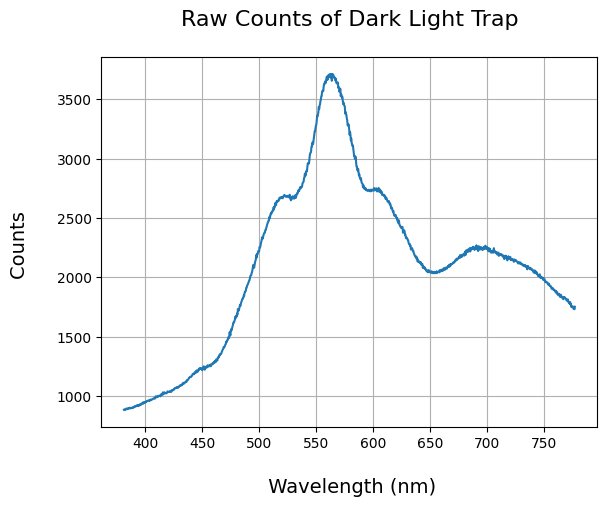

In [62]:
plt.plot(wavelengths, IS_Light_Trap)
plt.ylabel('Counts \n', fontsize = 14)
plt.xlabel('\n Wavelength (nm)', fontsize = 14)
plt.title('Raw Counts of Dark Light Trap\n', fontsize = 16)
plt.grid()

##### The second component of the baseline is the Ocean Optics Noise Floor.  To measure, disconnect the fiber at the ISP-REF Integrating Sphere.  Cover the fiber entrance with a soft opaque cloth, and measure the noise floor using the algorithm below.

In [13]:
input('STOP - Disconnect the fiber at the Integrating Sphere and cover the fiber input with a black cloth; Hit return')

STOP - Disconnect the fiber at the Integrating Sphere and cover the fiber input with a black cloth; Hit return


''

In [14]:
Spectrometer.from_first_available()
devices = list_devices()
spec = Spectrometer(devices[0])

spec.integration_time_micros(int_time[0])

In [15]:
dark = np.mean(scan_to_average(scans), axis=0)[110:110+1120]

In [16]:
spec.close()

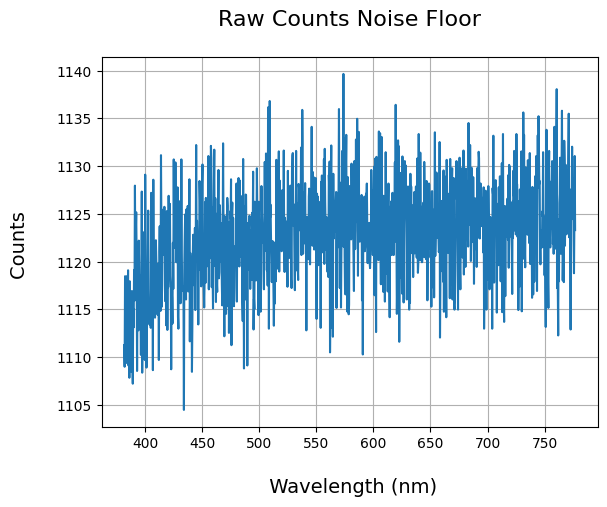

In [17]:
plt.plot(wavelengths, dark)
plt.ylabel('Counts \n', fontsize = 14)
plt.xlabel('\n Wavelength (nm)', fontsize = 14)
plt.title('Raw Counts Noise Floor\n', fontsize = 16)
plt.grid()

##### The baseline is the calculated from the teflon file, minus the summation of the just measured dark file and the measurement with the light trap positioned on top of the integrating sphere (as shown in the cell above).

In [18]:
baseline = np.subtract(teflon, np.add(dark,IS_Light_Trap))

wave = np.arange(400, 705, 5)

f = interpolate.interp1d(wavelengths, baseline)
baseline = f(wave)

##### You are now ready to measure reflectance spectrum of samples.  The process is similar to above, and is shown below:

##### Measure W1 through W6 of the MacBeth Color Checker (the grayscale color swatches)

In [19]:
Spectrometer.from_first_available()
devices = list_devices()
spec = Spectrometer(devices[0])

spec.integration_time_micros(int_time[0])

names_cal = ['W1_cal', 'W2_cal', 'W3_cal', 'W4_cal', 'W5_cal', 'W6_cal']

Uncorrected_cal_files = []

for i in names_cal:

    input('Place sample ' +str(i) + ' over Integrating Sphere Port and press <Enter>')
    spectrum = np.mean(scan_to_average(scans), axis = 0)[110:110+1120]
    Uncorrected_cal_files.append(spectrum)

spec.close()


Place sample W1_cal over Integrating Sphere Port and press <Enter>
Place sample W2_cal over Integrating Sphere Port and press <Enter>
Place sample W3_cal over Integrating Sphere Port and press <Enter>
Place sample W4_cal over Integrating Sphere Port and press <Enter>
Place sample W5_cal over Integrating Sphere Port and press <Enter>
Place sample W6_cal over Integrating Sphere Port and press <Enter>


##### Interpolate the above files to fit 400 through 700 nm in increments of 5 nm

In [20]:
interp_Uncorrected_cal_files = []

for i in Uncorrected_cal_files:
    f = interpolate.interp1d(wavelengths, i)
    temp = f(np.arange(400, 705, 5))
    interp_Uncorrected_cal_files.append(temp)

##### Import the industry accepted reflectance spectra for W1 through W6

In [21]:
names_ref = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']

df_ref = pd.read_csv('MacBeth_Color_Checker_Grayscale.csv', usecols = names_ref)[4:-16] # File

ref = np.array(df_ref.w1)

In [22]:
interp_Uncorrected_cal_files_1 = np.array(interp_Uncorrected_cal_files)   
cal_file = ref/(interp_Uncorrected_cal_files[0]/baseline)

In [23]:
step_one_cal_file = []

for i in interp_Uncorrected_cal_files_1:
    
#     plt.plot(np.arange(400, 705, 5), cal_file*(i/baseline))
    step_one_cal_file.append(cal_file*(i/baseline))
    
# plt.show()

##### Place measured and interpolated spectra in a dataframe

In [24]:
df_cal = pd.DataFrame(step_one_cal_file).T

df_cal.columns = names_ref

# df_cal.head()

##### Determining Polynomial Fit for each wavelength of W1 through W6

In [25]:
spectra_m, spectra_t = [], []

for i in range(len(df_cal.index)):
    spectra_m.append(df_cal.iloc[i])
    spectra_t.append(df_ref.iloc[i])

In [26]:
m = []

for i in range(len(spectra_m)):
    m.append(np.polyfit(spectra_m[i], spectra_t[i], 4))

In [27]:
# for i in range(len(m)):
#     print('f(x) = '+str(np.poly1d(m[i])))

##### Now ready for test sample

In [28]:
input('Place test sample over Integrating Sphere Port and press <Enter>')

Place test sample over Integrating Sphere Port and press <Enter>


''

In [45]:
Spectrometer.from_first_available()
devices = list_devices()
spec = Spectrometer(devices[0])

spec.integration_time_micros(int_time[0])

In [46]:
def scan_to_average(scans):
    
    spectra = []
    for i in np.arange(scans+1):
        spectra.append(spec.intensities())
            
    return spectra
    
scans = 100

sample = np.mean(scan_to_average(scans), axis=0)[110:110+1120]

In [47]:
spec.close()

In [48]:
f = interpolate.interp1d(wavelengths, sample)
wave = np.arange(400, 705, 5)
sample = f(wave)

sample = np.array(cal_file *(sample/baseline))

In [49]:
coef = []

for i in range(len(m)):
        coef.append(np.poly1d(m[i])(sample[i]))

In [50]:
title = input('Type the name of your sample: ')

Type the name of your sample: Yellow Swatch 3


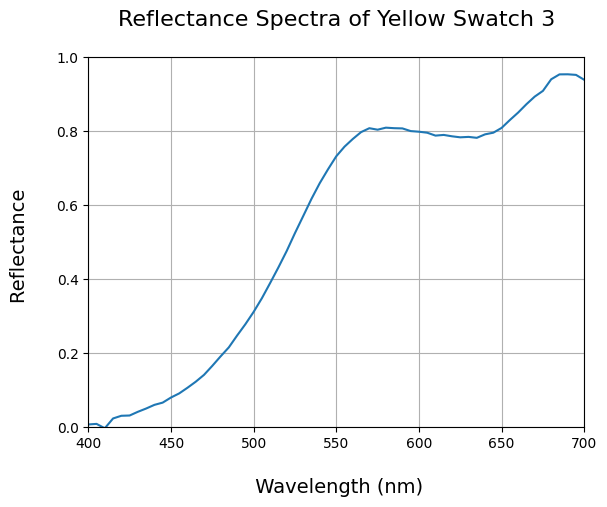

In [51]:
plt.plot(np.arange(400, 705, 5), coef)
plt.ylabel('Reflectance \n', fontsize = 14)
plt.xlabel('\n Wavelength (nm)', fontsize = 14)
plt.title('Reflectance Spectra of '+title+'\n', fontsize = 16)
plt.xlim(400, 700)
plt.ylim(0, 1)
plt.grid()
plt.savefig(title)

In [52]:
df = pd.DataFrame({'x': np.arange(400, 705, 5), 'y': coef})
df.to_csv(title+'.csv', sep=',', index = False)